# G parts

### Pre-processing:
- Extract, tokenize and split the data into training and test sets
- Make the corresponding y lists (actual pos/neg classification)

### Vectorize:
- Create the vocabulary (ie ordered unique tokens) from full data (train + test) to avoid having to handle unseen words later
- Transform into bag-of-words

### The model:

**Training**
- Hyperplane model, hinge loss (sum), l1 regularization, gradient descent
- Fixed learning rate and regularization dampening rate
- Preset max number of iteration and early exit condition*

This part was by far the most difficult. Since it is a class, and we are in a notebook, I did not know how to properly test my methods. Also, working with numpy assumes one understands the shapes of their arrays. That assumption was very wrong for a very long time. The debugging was (a never-ending torture) mostly done in the python console, trying things out manually, and I ended up getting external help as well.

*Since we use calculate the loss _sum_ (as per the instructions), the initial loss decrease threshold (0.001) for the early exit condition was way too small. This caused a huge overfitting on the training data, which I only realized when using the test data. I adapted it to the size of the training data and the model does way better now, though I think it can be further tweaked.

**Prediction**
- Additional sign function layer

### The hyperparameters:
- Train with 10 pairs of random learning rate and regularizer dampening
- Keep the ones with the best accuracy.

### Testing
I got ~84% accuracy, which is good in the sense that it is above the required 80% to pass this assignment. But! I think it would be better if the difference between the training accuracy (100%, I think the model is still overfitted) and the test accuracy was smaller.

## Part 1: Parsing the dataset

In [1]:
import os.path
import tarfile
from urllib.request import urlretrieve

from spyder.utils.snippets.lexer import tokenize

url = """http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz"""
if not os.path.exists(url.split("/")[-1]):
  urlretrieve(url, url.split("/")[-1])
  print("Downloaded", url)
  with tarfile.open('review_polarity.tar.gz', 'r:gz') as tar:
    tar.extractall()
  print("Extracted archive")

In [2]:
import os
import numpy as np

In [3]:
# takes a path and returns a list with the content of all files at that path
def get_reviews(path):
    filenames_lst = os.listdir(path)
    reviews_lst = []
    for i in range(len(filenames_lst)):
        path_full = os.path.join(path, filenames_lst[i])
        with open(path_full, 'r') as f:
            reviews_lst.append(f.read())
    return reviews_lst

folder_name = 'txt_sentoken'
neg_path = os.path.join(folder_name, 'neg')
pos_path = os.path.join(folder_name, 'pos')
neg_reviews = get_reviews(neg_path)
pos_reviews = get_reviews(pos_path)

In [4]:
# check that both lists are the correct length
assert len(neg_reviews) == 1000
assert len(neg_reviews) == len(pos_reviews)

In [5]:
# create the full list
X_full = neg_reviews + pos_reviews

# create the training list and testing list
split_point = int(len(neg_reviews)*0.8)
X_train = neg_reviews[:split_point] + pos_reviews[:split_point]
X_test = neg_reviews[split_point:] + pos_reviews[split_point:]

# create the corresponding outcome lists
y_full = [-1 for i in range(int(len(X_full)/2))] + [1 for i in range(int(len(X_full)/2))]
y_train = [-1 for i in range(split_point)] + [1 for i in range(split_point)]
y_test = [-1 for i in range(int(len(X_test)/2))] + [1 for i in range(int(len(X_test)/2))]

In [6]:
# check the train and test lists are the correct lengths
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

# check the train and test lists are the correct types / values
assert np.all([isinstance(x, str) for x in X_train])
assert np.all([isinstance(x, str) for x in X_test])
assert len(np.unique(y_train))==2
assert min(y_train) == -1
assert max(y_train) == 1
assert len(np.unique(y_test))==2
assert min(y_test) == -1
assert max(y_test) == 1

## Part 2: Feature extraction

In [7]:
class Vectorizer:

    # the instance will only store the vocabulary once the make_vocabulary method has been used
    def __init__(self):
        self.vocabulary = None

    @staticmethod
    def tokenize(txt):
        return [token for line in txt.split("\n") for token in line.split()]

    # takes a list of texts and creates the vocabulary (list of unique tokens)
    def make_vocabulary(self, data):
        """ not efficient: many tokens appear in many reviews so the 2nd for loop will iterate over the same token many times """
        vocab = []
        for review in data:
            for token in self.tokenize(review):
                if token not in vocab:
                    vocab.append(token)
        self.vocabulary = vocab

    # takes a list of texts and returns its corresponding bag-of-words vector, according to the vocabulary
    def transform_to_bow(self, data_list):
        matrix_size = (len(data_list), len(self.vocabulary))
        X = np.zeros(matrix_size)
        for i, txt in enumerate(data_list):
            for token in self.tokenize(txt):
                X[i, self.vocabulary.index(token)] = 1
        return X

In [8]:
vectorizer = Vectorizer()

# create the vocabulary
""" both train and test sets are included in the vocabulary, to avoid unseen words later """
vectorizer.make_vocabulary(X_full)

# turns the lists into bag_of_words matrices
X_train_bow = vectorizer.transform_to_bow(X_train)
X_test_bow = vectorizer.transform_to_bow(X_test)

# transform the y lists into np arrays for an easier time down the line
y_train = np.array(y_train)
y_test = np.array(y_test)

In [9]:
# get the vocabulary
ordered_vocabulary = vectorizer.vocabulary

In [10]:
assert X_test_bow.shape[1] == X_train_bow.shape[1]

## Part 3: Learning framework

In [11]:
class Classifier:
    def __init__(self, vocabulary, n_max_iter=200, regularizer_dampening=0.001, learning_rate=0.1):
        self.param_vector = np.random.normal(size=len(vocabulary)+1)
        self.n_max_iter = n_max_iter
        self.lambduh = regularizer_dampening
        self.gamma = learning_rate
        self.loss = []

    def _score(self, X):
        z = np.matmul(X, self.param_vector) # internet says matmul is more efficient than dot for matrices
        return z

    def _loss(self, X, y):
        """ - Instructions mention both L1 and l2 regularization, I did l1, hopefully that's ok
        - Why do loss sum when we could do loss average ?
        - Also, the intercept (first element of model.param_vector) gets regularized, maybe that's a problem? """
        z = self._score(X) # gets the score, not the prediction
        loss_vector = np.maximum(0,1-np.multiply(y,z)) # hinge loss
        regularization = self.lambduh * np.sum(np.absolute(self.param_vector)) # l1 regularization
        loss = regularization + np.sum(loss_vector) # loss sum instead of average?
        self.loss.append(loss)
        return loss

    def _gradient(self, X, y):
        v1 = np.multiply(y, self._score(X))
        index = v1 < 1 # condition
        v = np.zeros(X.shape)
        v[index] = -y[index].reshape((-1,1)) * X[index] # reshape so multiplication works
        return self.lambduh * np.sign(self.param_vector) + np.sum(v, axis=0) # sum on row axis, not colum

    def fit(self, X, y):
        """ the early exit condition does not make sense to me, so I did this instead:
        loss_best > loss_curr > loss_best-0.1 """ # using 0.001 is too 'severe' with the loss sum
        X = np.insert(X, 0, 1, 1) # add the pseudo-input
        i = 0
        counter = 0
        threshold = 0.1 * X.shape[0]
        loss_best = 999999999
        while i < self.n_max_iter and counter < 5:
            loss_curr = self._loss(X, y)
            self.param_vector = self.param_vector - self.gamma * self._gradient(X, y)

            # exit early if the loss hasn't decreased by more than 0.1 in 5 consecutive iterations
            if i > 1:
                if loss_best > loss_curr and loss_curr > loss_best - threshold:
                    counter += 1
                else:
                    counter = 0

            if loss_curr < loss_best:
                loss_best = loss_curr

            i += 1
        return self

    def predict(self, X):
        """ np.sign can return 0, maybe that's a problem? """
        X = np.insert(X, 0, 1, 1) # add the pseudo input
        z = self._score(X)
        y_hat = np.sign(z)
        return y_hat

model = Classifier(ordered_vocabulary, n_max_iter=500)
model.fit(X_train_bow, y_train) # training

In [12]:
model.predict(X_train_bow)

array([-1., -1., -1., ...,  1.,  1.,  1.], shape=(1600,))

In [13]:
import matplotlib.pyplot as plt

def show_plot(data, x_label, y_label, size=(20,10)):
    plt.figure(figsize=size)
    plt.plot(data)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

I wanted to see what the loss looked like, so I plotted it.

I am not sure I understand why it is so squiggly at first, but it does converge nicely in just ~50 iterations.

The model is trained in 108 iterations (~14 seconds for me). Before I corrected the early exit condition it would take just under a minute and run for ~160 iterations.

The last 25 iterations show there is still a 'big' decrease in loss for each iteration, but since we _sum_ the loss over the 1600 training data points, it is in fact relatively small, which is why the model exited the training loop early.

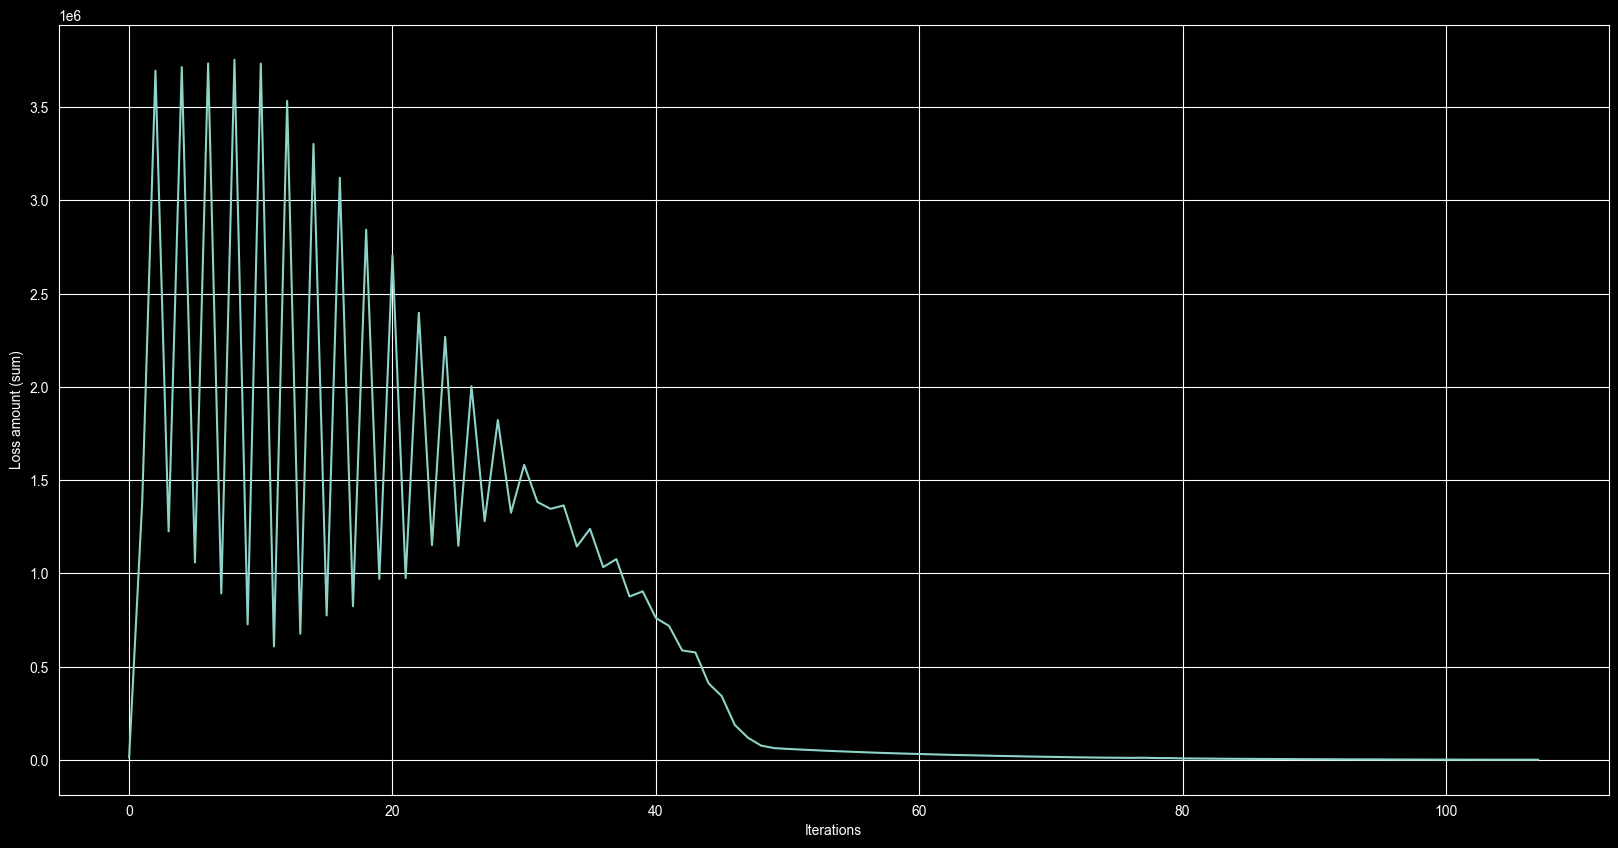

In [14]:
show_plot(model.loss, "Iterations", "Loss amount (sum)")

In [15]:
len(model.loss)

108

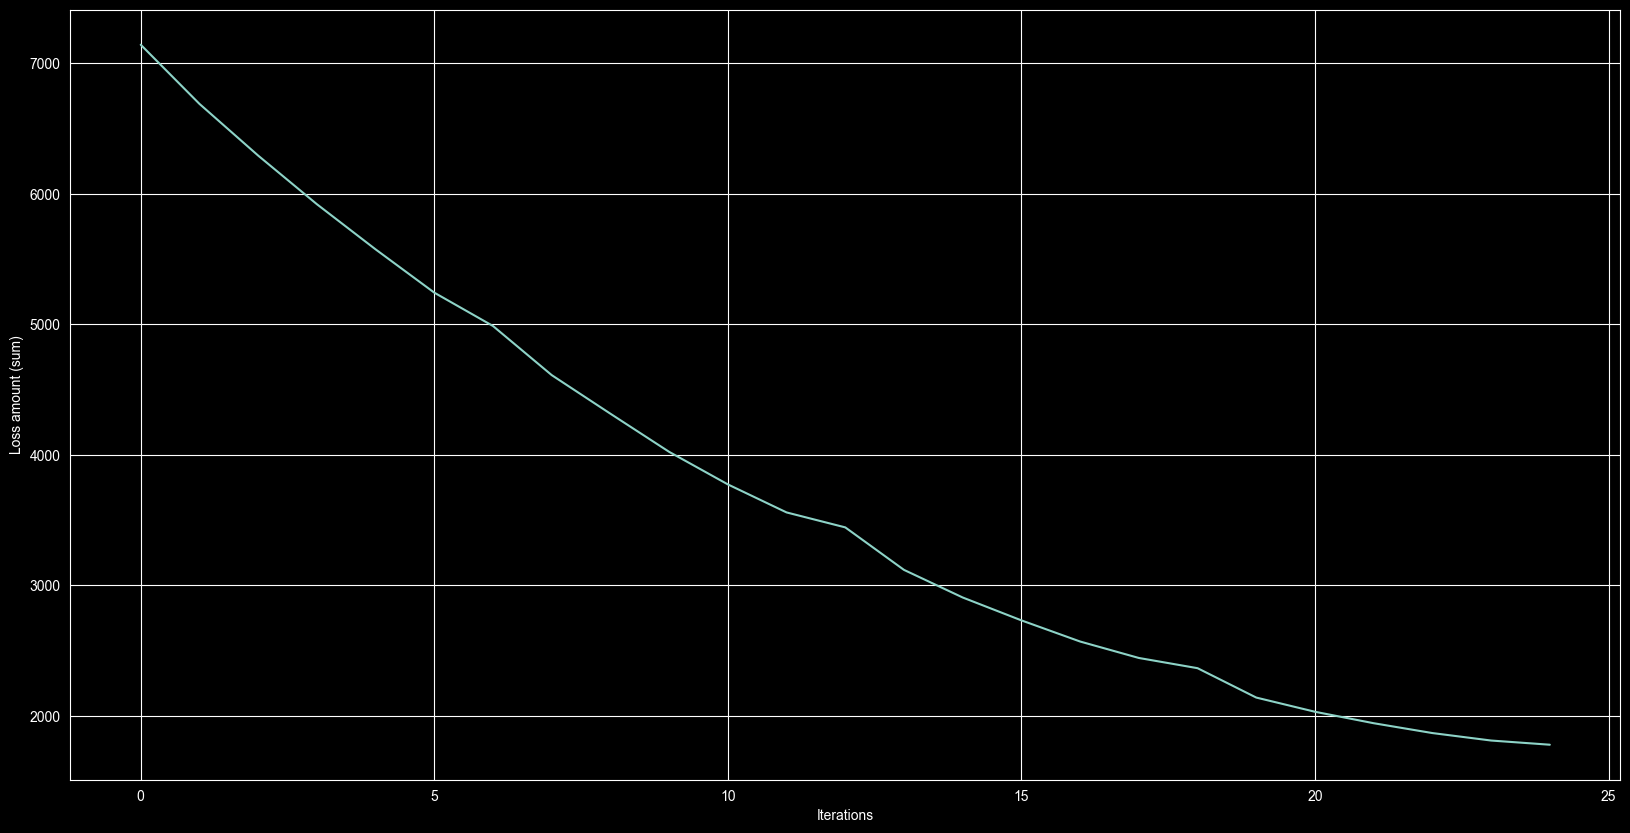

In [16]:
show_plot(model.loss[-25:], "Iterations", "Loss amount (sum)")

The vocabulary was built on the negative reviews first, than the positive reviews. And it contains unique tokens in their order of first appearance.

The first tokens in the vocabulary first appeared in the negative reviews, but we do not know how often they appeared in the next reviews. The last tokens in the vocabulary appeared only in the last positive reviews.

Here, the first ~1000 tokens have very high weights, either negative or positive, compared to the last tokens. Because of my previous point, I do not know how to interpret that. It could be that some appear very often and exclusively in one category, but we cannot know for sure with this graph only.

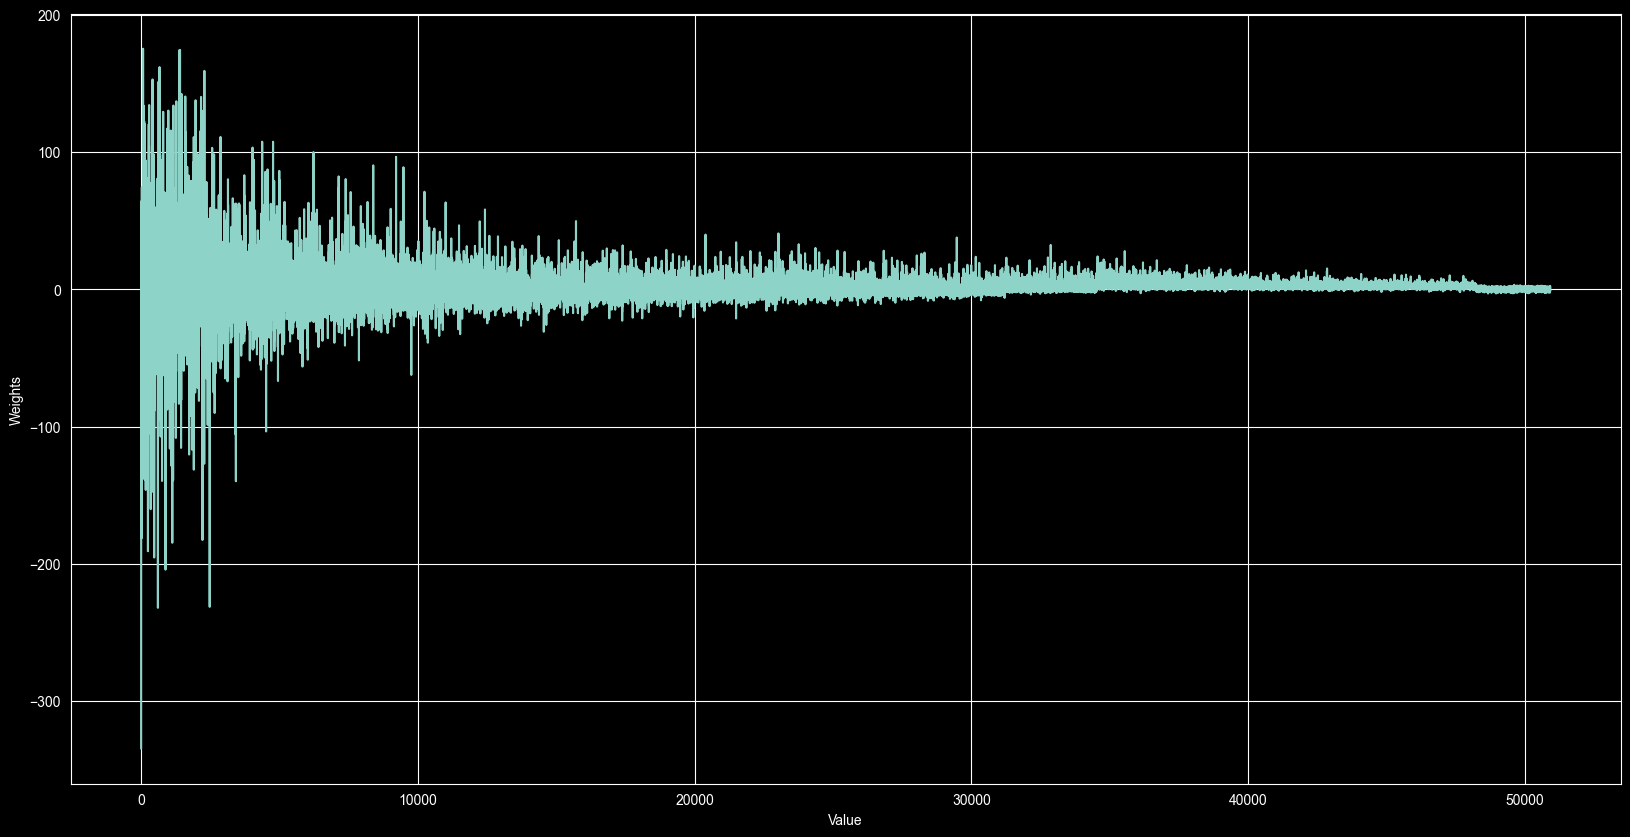

In [17]:
show_plot(model.param_vector[1:], "Value", "Weights")

In [18]:
assert len(model.param_vector[1:]) == len(ordered_vocabulary)

Most of 'heaviest' tokens make sense. Words with a negative connotation (eg. awful, least, stupid, etc.) indicate the review is most likely negative. Some were less expected though: eg. 'performances' and 'life'. I think they maybe are often used in combination with other words (maybe 'good performances', or 'best ... of my life' for example?).

Although we can achieve good enough accuracy, I think the model is way too simple, and would be better if it took into account the joint use of certain tokens. For example, the word 'very' influences the model to classify a review as positive, but the phrase could be 'very bad', and if the weight 'bad' is not high enough, the model's prediction will be incorrect.

Also, we could calculate precision and recall for a more thorough analysis I guess.

In [19]:
idx = np.argsort(np.abs(model.param_vector[1:]))

print("                Word   Weight  Occurences")
for i in idx[-20:]:   # Pick those with highest 'voting' values
    print("%20s   %.3f\t%i " % (ordered_vocabulary[i], model.param_vector[i+1], np.sum([ordered_vocabulary[i] in d for d in X_train])))

                Word   Weight  Occurences
               awful   -146.181	130 
               least   -147.583	407 
        performances   151.145	290 
                life   152.799	707 
           hilarious   159.042	163 
               looks   -160.214	301 
                very   161.770	1247 
              stupid   -169.443	181 
                both   174.202	544 
                best   174.222	693 
                also   175.169	850 
                   ?   -181.252	990 
       unfortunately   -182.667	271 
            supposed   -184.682	246 
             nothing   -190.833	479 
              boring   -195.419	184 
              script   -204.265	511 
               worst   -231.374	199 
                plot   -232.067	806 
                 bad   -334.694	668 


## Part 4: Exploring hyperparameters


In [20]:
# Define the parameters
n_samples = 10
best_hparam = None

It seems I get the worst accuracy values when the learning rate is high and the regularizer dampening  is low.

In [21]:
print("Learning rate:\tReg.dampening:\tTraining set accuracy:")
for a, b in zip(np.random.choice(np.logspace(-4, 3, num=1000), n_samples), np.random.choice(np.logspace(-4, 3, num=1000), n_samples)):

  # Set up the classifier
  model = Classifier(ordered_vocabulary, regularizer_dampening=a, learning_rate=b)

  # Train the classifier
  model.fit(X_train_bow, y_train)

  # Calculate the training accuracy
  train_accuracy = np.sum(model.predict(X_train_bow) == y_train) / len(y_train)

  # Store the hyperparameters if they are better than what we have found before
  if best_hparam is None or best_hparam[2] < train_accuracy:
    best_hparam = (a, b, train_accuracy)
  print("%.3f\t\t%.3f\t\t%.1f%%" % (a, b, 100 * train_accuracy))

best_a = best_hparam[0]
best_b = best_hparam[1]
print("Best parameters: %.5f, %.5f" % (best_a, best_b))

Learning rate:	Reg.dampening:	Training set accuracy:
0.000		0.142		99.5%
0.007		606.433		100.0%
0.000		0.178		99.9%
3.002		6.009		93.9%
0.517		0.000		49.7%
0.003		10.069		100.0%
180.824		0.008		50.0%
0.003		0.005		94.9%
0.071		0.285		100.0%
0.681		0.015		99.7%
Best parameters: 0.00674, 606.43294


In [22]:
# Set up the classifier
model = Classifier(ordered_vocabulary, regularizer_dampening=best_a, learning_rate=best_b)

# Train on all the non-test data
model.fit(X_train_bow, y_train)

# Run prediction on the test set
test_accuracy = np.sum(model.predict(X_test_bow)==y_test)/len(y_test)

print("Test set accuracy %.1f%%" % (100*test_accuracy))

Test set accuracy 84.8%


# VG parts

Split data according to k-fold cross validation:
- Get k equally sized sets of random indices and fetch from X and y using the indices
- Usually k = 10

Do tf-idf and bow on all k sets:
- tf:
- idf:

Train and test using SGD_AdaM:
- SGD: use one datapoint (or a mini set) instead of the whole dataset, on each iteration
- [AdaM](https://www.youtube.com/watch?v=HrxQ81OcZwM): adapt the learning rate with velocity and forgetting factor

AdaM seems to be the best solution (not incl. solutions that calculate Hessian matrices). It improves on both Momentum and RMSProp (which itself improved on AdaGrad).

Find best hyperparameters incl. decay rates?

Do it k times:
- Calculate accuracy each time
- Average the accuracies to get final value
- Compare tf-idf vs bow

In [23]:
class Vectorizer_but_better(Vectorizer):

    # vocab as a dict with freq values?

    def transform_to_tfidf(self):
        pass

In [24]:
class SGDClassifier_AdaM(Classifier):

    def __init__(self):
        #super().__init__()
        #self.eta = constant <1 (decay rate for velocity)
        #self.last_velocity = (mean of gradients)
        #sel.rho = (decay rate for gradients)
        #self.last_gradient = constant <1 (mean of squared gradients)
        #self.epsilon = tiny constant to avoid division by zero
        pass

        #bias correction???

    def _gradient(self, X, y):
        #self.param_vector = self.param_vector - self.gamma * self.last_velocity / sqrt(self.last_gradient + self.epsilon)
        pass

# PLEASE FAIL ME, I WANT THE VG GRADE BUT DID NOT FINISH IN TIME (obviously)